In [4]:
from __future__ import print_function, division
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import re
import pandas as pd
import os
import datetime
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [13]:
data=pd.read_csv('https://raw.githubusercontent.com/divyansh1195/Car-Price-Prediction/main/car%20data.csv')

In [14]:
data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [16]:
data.shape

(301, 9)

From the dataset preview, Selling_Price is the dependent variable and the rest are independent variables

# Checking if there are any missing values

In [17]:
data.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

There are no missing values in the dataset

# Checking cardinality of independent categorical variables in the dataset

In [18]:
print('Unique elements in Seller_Type are',data['Seller_Type'].unique())
print('Unique elements in Fuel_Type are',data['Fuel_Type'].unique())
print('Unique elements in Transmission are',data['Transmission'].unique())
print('Unique elements in Owner are',data['Owner'].unique())
print('Unique elements in Year are',data['Year'].unique())

Unique elements in Seller_Type are ['Dealer' 'Individual']
Unique elements in Fuel_Type are ['Petrol' 'Diesel' 'CNG']
Unique elements in Transmission are ['Manual' 'Automatic']
Unique elements in Owner are [0 1 3]
Unique elements in Year are [2014 2013 2017 2011 2018 2015 2016 2009 2010 2012 2003 2008 2006 2005
 2004 2007]


In [19]:
print('Unique elements in Car_Name are',data['Car_Name'].nunique())
#98 unique elements 
#so, rather than encoding it, we can just drop this columbn as it doesn' make sense

Unique elements in Car_Name are 98


In [20]:
data.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


# Feature Engineering

Dropping the Car_Name Column

In [21]:
dataset=data[['Year','Selling_Price','Present_Price','Kms_Driven','Fuel_Type','Seller_Type','Transmission','Owner']]
dataset.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


Let's make a feature variable 'Present_Year' which has all the element values as 2020. On subtracting 'Present_Year' and 'Year', we can make another feature variable as 'Number_of_Years_Old', which gives us idea about how old the car is.

In [22]:
dataset['Present_Year']=2020
dataset['Number_of_Years_Old']=dataset['Present_Year']- dataset['Year']
dataset.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Present_Year,Number_of_Years_Old
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,2020,6
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,2020,7
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,2020,3
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,2020,9
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,2020,6


So, we can now safely drop 'Year' and 'Present_Year' columns

In [23]:
dataset.drop(labels=['Year', 'Present_Year'],axis=1,inplace=True)
dataset.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Number_of_Years_Old
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,6
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,7
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,3
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,9
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,6


# Encoding the Categorical Variables

In [24]:
#select categorical variables from then dataset, and then implement categorical encoding for nominal variables
Fuel_Type=dataset[['Fuel_Type']]
Fuel_Type=pd.get_dummies(Fuel_Type, drop_first=True)

Seller_Type=dataset[['Seller_Type']]
Seller_Type=pd.get_dummies(Seller_Type, drop_first=True)

Transmission=dataset[['Transmission']]
Transmission=pd.get_dummies(Transmission, drop_first=True)

dataset=pd.concat([dataset,Fuel_Type, Seller_Type, Transmission], axis=1)

dataset.drop(labels=['Fuel_Type', 'Seller_Type', 'Transmission'], axis=1, inplace=True)

dataset.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Number_of_Years_Old,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,6,0,1,0,1
1,4.75,9.54,43000,0,7,1,0,0,1
2,7.25,9.85,6900,0,3,0,1,0,1
3,2.85,4.15,5200,0,9,0,1,0,1
4,4.60,6.87,42450,0,6,1,0,0,1


In [25]:
dataset.columns

Index(['Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner',
       'Number_of_Years_Old', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol',
       'Seller_Type_Individual', 'Transmission_Manual'],
      dtype='object')

Now, the encoding has been done

In [26]:
# Dataset Correlation
dataset.corr()

,Selling_Price,Present_Price,Kms_Driven,Owner,Number_of_Years_Old,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
Selling_Price,1.000000,0.878983,0.029187,-0.088344,-0.236141,0.552339,-0.540571,-0.550724,-0.367128
Present_Price,0.878983,1.000000,0.203647,0.008057,0.047584,0.473306,-0.465244,-0.512030,-0.348715
Kms_Driven,0.029187,0.203647,1.000000,0.089216,0.524342,0.172515,-0.172874,-0.101419,-0.162510
Owner,-0.088344,0.008057,0.089216,1.000000,0.182104,-0.053469,0.055687,0.124269,-0.050316
Number_of_Years_Old,-0.236141,0.047584,0.524342,0.182104,1.000000,-0.064315,0.059959,0.039896,-0.000394
Fuel_Type_Diesel,0.552339,0.473306,0.172515,-0.053469,-0.064315,1.000000,-0.979648,-0.350467,-0.098643
Fuel_Type_Petrol,-0.540571,-0.465244,-0.172874,0.055687,0.059959,-0.979648,1.000000,0.358321,0.091013
Seller_Type_Individual,-0.550724,-0.512030,-0.101419,0.124269,0.039896,-0.350467,0.358321,1.000000,0.063240
Transmission_Manual,-0.367128,-0.348715,-0.162510,-0.050316,-0.000394,-0.098643,0.091013,0.063240,1.000000


# Data Visualization and Correlation

<AxesSubplot:>

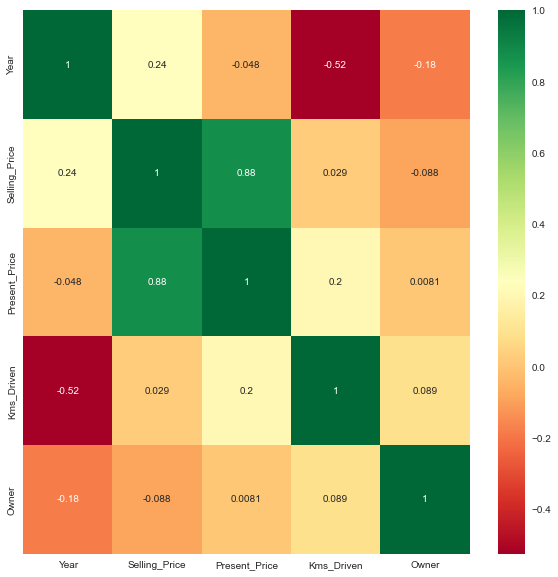

In [27]:
#Correlations of features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#Plot heat map
sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [28]:
sell=dataset['Selling_Price']
dataset.drop(['Selling_Price'], axis=1, inplace=True)
dataset=dataset.join(sell)
dataset.head()

,Present_Price,Kms_Driven,Owner,Number_of_Years_Old,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,Selling_Price
0,5.59,27000,0,6,0,1,0,1,3.35
1,9.54,43000,0,7,1,0,0,1,4.75
2,9.85,6900,0,3,0,1,0,1,7.25
3,4.15,5200,0,9,0,1,0,1,2.85
4,6.87,42450,0,6,1,0,0,1,4.60


In [29]:
X=dataset.iloc[:,:-1]
y=dataset.iloc[:,-1]

[4.06474610e-01 4.43652402e-02 3.56204489e-04 7.36545598e-02
 2.10486753e-01 5.37554252e-03 1.29523310e-01 1.29763780e-01]


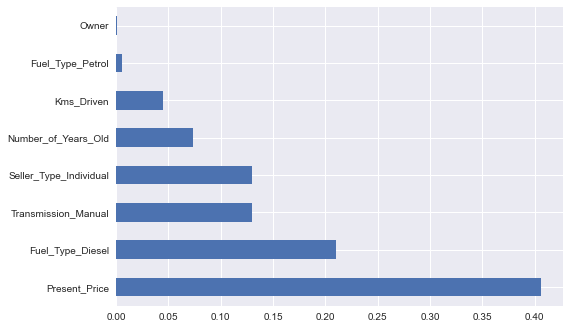

In [30]:
### To determine important features, make use of ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)

print(model.feature_importances_)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

'Owner' has zero feature importance i.e. nil on the dependent variable, 'Selling_Price'

# Model Building and Training

In [31]:
X=dataset.iloc[:,:-1].values
y=dataset.iloc[:,-1].values

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import StratifiedKFold
#kfold = StratifiedKFold(n_splits=3)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Decision Tree Regressor

Decision Tree Score on Training set is 1.0
Decision Tree Score on Test Set is 0.9202815383374512
[0.9542394  0.84409548 0.69916028 0.924205   0.92156403]
Accuracy: 86.87 %
Standard Deviation: 9.22 %
Mean Absolute Error: 0.8102197802197801
Mean Squared Error: 2.3840648351648355
RMSE: 1.5440417206684653
The r2_score is 0.9202815383374512


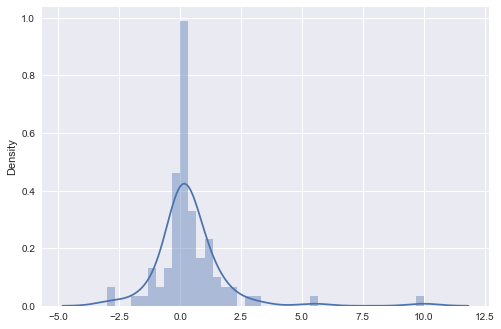

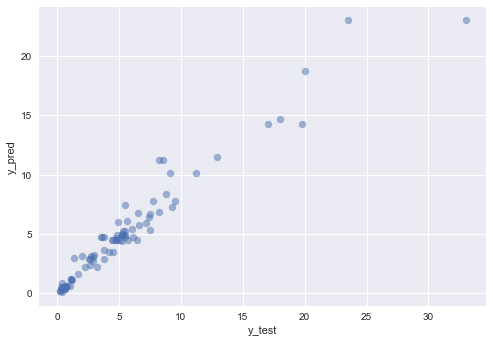

In [34]:
#Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state = 0)
dt_reg.fit(X_train, y_train)
y_pred=dt_reg.predict(X_test)

print("Decision Tree Score on Training set is",dt_reg.score(X_train, y_train))#Training Accuracy
print("Decision Tree Score on Test Set is",dt_reg.score(X_test, y_test))#Testing Accuracy

accuracies = cross_val_score(dt_reg, X_train, y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

mae=mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error:" , mae)

mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error:" , mse)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('The r2_score is', metrics.r2_score(y_test, y_pred))

sns.distplot(y_test-y_pred)
plt.show()

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Random Forest Regressor

Random Forest Score on Training set is 0.9117360962778457
Random Forest Score on Test Set is 0.869296426787262
[0.95007004 0.8222006  0.6392082  0.83264481 0.92767529]
Accuracy: 83.44 %
Standard Deviation: 10.98 %
Mean Absolute Error: 0.8824073487151024
Mean Squared Error: 3.908828472454975
RMSE: 1.9770757376628176
The r2_score is 0.869296426787262


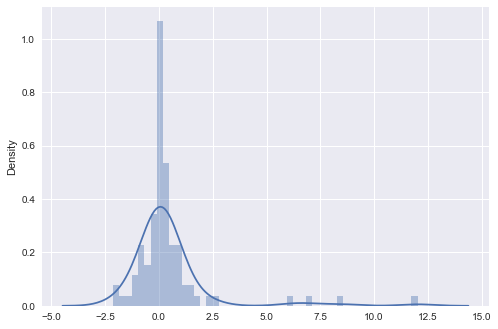

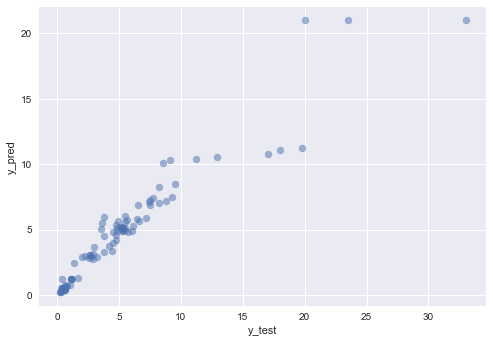

In [35]:
#Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=400,min_samples_split=15,min_samples_leaf=2,
max_features='auto', max_depth=30)
rf_reg.fit(X_train, y_train)
y_pred=rf_reg.predict(X_test)

print("Random Forest Score on Training set is",rf_reg.score(X_train, y_train))#Training Accuracy
print("Random Forest Score on Test Set is",rf_reg.score(X_test, y_test))#Testing Accuracy

accuracies = cross_val_score(rf_reg, X_train, y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

mae=mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error:" , mae)

mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error:" , mse)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('The r2_score is', metrics.r2_score(y_test, y_pred))

sns.distplot(y_test-y_pred)
plt.show()

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Voting Regressor

Voting Regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset to average the individual predictions to form a final prediction.

Voting Regresssor Score on Training set is 0.97753180334386
Voting Regresssor Score on Test Set is 0.9000209436722089
[0.97078768 0.83819967 0.68085126 0.89899668 0.94163523]
Accuracy: 86.61 %
Standard Deviation: 10.28 %
Mean Absolute Error: 0.8271623177715001
Mean Squared Error: 2.989979328163951
RMSE: 1.7291556691529977
The r2_score is 0.9000209436722089


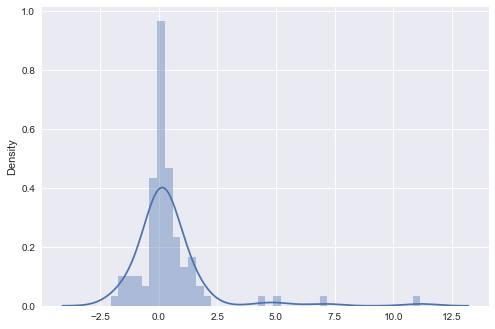

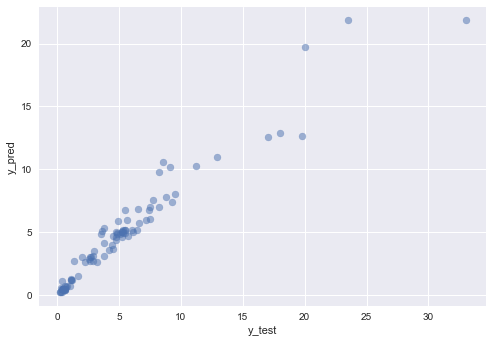

In [36]:
from sklearn.ensemble import VotingRegressor
vot_reg = VotingRegressor([('DecisionTree', dt_reg), ('RandomForestRegressor', rf_reg)])
vot_reg.fit(X_train, y_train)
y_pred=vot_reg.predict(X_test)

print("Voting Regresssor Score on Training set is",vot_reg.score(X_train, y_train))#Training Accuracy
print("Voting Regresssor Score on Test Set is",vot_reg.score(X_test, y_test))#Testing Accuracy

accuracies = cross_val_score(vot_reg, X_train, y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

mae=mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error:" , mae)

mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error:" , mse)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('The r2_score is', metrics.r2_score(y_test, y_pred))

sns.distplot(y_test-y_pred)
plt.show()

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

So, the XGBoost Regressor gave us best scores on the Training Dataset

# Dump the model selected as a Pickle File

In [37]:
import pickle
pickle.dump(vot_reg, open("vot_reg.pkl", "wb"))

# load model from file
model = pickle.load(open("vot_reg.pkl", "rb"))

model.predict([[9.85, 6900, 0, 3, 0, 1, 0, 1]])

array([7.36508547])